This script created a test case for mosquito simulation using FEniCSX.

The Neches River fort.64.nc are used to determine which node has abs(water velocity) < 0.001

2024.9.14.

In [34]:
import sys

#import Kalpana functions from github repository
# change these to your own paths!
sys.path.append('/Users/liting/Documents/GitHub/Kalpana')
from kalpana.export import *
from kalpana.visualizations import *
import contextily as cx
import os
import geopandas as gpd
import rasterio
import numpy as np
from rasterio.features import rasterize
from netCDF4 import Dataset
#from modified_functions import *
threshold_value = 1.0


In [35]:
#plot the maximum water levels from a given maxele.63.nc file

## path to netcdf file
### netcdf is just a way to store datasets
nc_path_2 = '/Users/liting/Documents/GitHub/Kalpana/examples/test/fort.64.nc' 
nc2 = netcdf.Dataset(nc_path_2, 'r')
#check if this netcdf file looks right
print(nc2)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    _FillValue: -99999.0
    model: ADCIRC
    version: v55.00-49-ga2c71f6
    grid_type: Triangular
    description: CTXCS_TP_0012_HIS                         ! 32 CHARACTER ALPHANUMERIC RUN DESCRI
    agrid: Modified fort.14
    rundes: CTXCS_TP_0012_HIS                         ! 32 CHARACTER ALPHANUMERIC RUN DESCRI
    runid: Tides_1_SLC_0_RFC_0_WAV_1_GCP_CTX61LE02                          ! 24 CHARACTER
    title: namo
    institution: namo
    source: namo
    history: namo
    references: namo
    comments: namo
    host: namo
    convention: namo
    Conventions: UGRID-0.9.0
    contact: namo
    creation_date: 2023-03-23 14:52:27 -05:00
    modification_date: 2023-03-23 14:52:27 -05:00
    fort.15: ==== Input File Parameters (below) ====
    dt: 0.125
    ihot: 0
    ics: 2
    nolibf: 1
    nolifa: 2
    nolica: 1
    nolicat: 1
    nwp: 7
    ncor: 1
    ntip: 0
    nws: 0
    nra

To be lazy, we try to use as much Kalpana code as possible. Therefore, the path to choose is: obtain an array indicate stagnated water with binary coding, and store it as a new variable in netCDF file. In this way, later we can just pass this netCDF file to modified Kalpana function to generate shapefile.

Two functions in original Kalpana are modified so it is easier for us to use here (add 63 to function name)

In [3]:
def nc2shp63(ncFile, var, levels, conType, pathOut, epsgOut, vUnitOut='ft', vUnitIn='m', epsgIn=4326,
           subDomain=None, epsgSubDom=None, exportMesh=False, meshName=None, dzFile=None, zeroDif=-20,time_index=0):
    ''' Run all necesary functions to export adcirc outputs as shapefiles.
        Parameters
            ncFile: string
                path of the adcirc output, must be a netcdf file
            var: string
                Name of the variable to export
            levels:list
                Contour levels. Min, Max and Step. Max IS included as in np.arange method.
                Values must be in vUnitOut vertical unit.
            conType: string
                'polyline' or 'polygon'
            pathout: string
                complete path of the output file (*.shp or *.gpkg)
            epsgOut: int
                coordinate system of the output shapefile
            vUnitIn, vUnitOut: string. Default for vUnitIn is 'm' and 'ft' for vUnitOut
                input and output vertical units. For the momment only supported 'm' and 'ft'
            epsgIn: int. Default 4326.
                coordinate system of the adcirc input
            subDomain: str or list. Default None
                complete path of the subdomain polygon kml or shapelfile, or list with the
                uper-left x, upper-left y, lower-right x and lower-right y coordinates. The crs must be the same of the
                adcirc input file.
            exportMesh: boolean. Default False
                True for export the mesh geodataframe and also save it as a shapefile
            meshName: str
                file name of the output mesh shapefile
            dzFile: str
                full path of the pickle file with the vertical difference between datums
                for each mesh node
            zeroDif: int
                threshold for using nearest neighbor interpolation to change datum. Points below
                this value won't be changed.
        Returns
            gdf: GeoDataFrame
                gdf with contours
            mesh: GeoDataFrame, only if exportMesh is True
                gdf with mesh elements, representative length and area of each triangle
    '''
    
    print('Start exporting adcirc to shape')
    ## read adcirc file
    nc = netcdf.Dataset(ncFile, 'r')
    ## change units of the requested levels
    if vUnitIn == 'm' and vUnitOut == 'ft':
        levels = [l / 3.2808399 for l in levels]
    elif vUnitIn == 'ft' and vUnitOut == 'm':
        levels = [l * 3.2808399 for l in levels]
    if conType == 'polygon':   
        maxmax = np.max(nc[var][:].data)
        orgMaxLevel = levels[1]
        stepLevel = levels[2]
        ## list of levels to array
        levels_aux = np.arange(levels[0], np.ceil(maxmax), stepLevel)
        ## given levels will now match the avarege value of each interval    
        levels_aux = levels_aux - stepLevel/2
        levels = levels_aux.copy()
    else:
        orgMaxLevel = levels[1]
        stepLevel = levels[2]
        levels = np.arange(levels[0], orgMaxLevel + stepLevel, stepLevel)
    
    t00 = time.time()
    gdf = runExtractContours63(nc, var, levels, conType, epsgIn, stepLevel, orgMaxLevel, 
                            dzFile, zeroDif,time_index)
    print(f'    Ready with the contours extraction: {(time.time() - t00)/60:0.3f} min')
    
    ## clip contours if requested
    if subDomain is not None:
        t0 = time.time()
        subDom = readSubDomain(subDomain, epsgSubDom)
        gdf = gpd.clip(gdf, subDom.to_crs(epsgIn))
        print(f'    Cliping contours based on mask: {(time.time() - t0)/60:0.3f} min')
    
    ## change vertical units if requested
    if vUnitIn == vUnitOut:
        pass
    else:
        t0 = time.time()
        gdf = gdfChangeVerUnit(gdf, vUnitIn, vUnitOut)
        print(f'    Vertical units changed: {(time.time() - t0)/60:0.3f} min')
    
    ## change CRS if requested
    if epsgIn == epsgOut:
        pass
    else:
        t0 = time.time()
        gdf = gdf.to_crs(epsgOut)
        print(f'    Changing CRS: {(time.time() - t0)/60:0.3f} min')
    
    ## save output shape file
    t0 = time.time()
    if pathOut.endswith('.shp'):
        gdf.to_file(pathOut)
    elif pathOut.endswith('.gpkg'):
        gdf.to_file(pathOut, driver = 'GPKG')
    elif pathOut.endswith('.wkt'):
        gdf.to_csv(pathOut)
    print(f'    Saving file: {(time.time() - t0)/60:0.3f} min')
    
    ## export mesh if requested
    if exportMesh == True:
        print('    Exporting mesh')
        t0 = time.time()
        mesh = mesh2gdf(nc, epsgIn, epsgOut)
        
        if subDomain is not None:
            mesh = gpd.clip(mesh, subDom.to_crs(epsgOut))
        
        mesh.to_file(os.path.join(os.path.dirname(pathOut), f'{meshName}.shp'))
        print(f'    Mesh exported: {(time.time() - t0)/60:0.3f} min')
        print(f'Ready with exporting code after: {(time.time() - t00)/60:0.3f} min')
        return gdf, mesh
    
    else:
        print(f'Ready with exporting code after: {(time.time() - t00)/60:0.3f} min')
        return gdf
    


def runExtractContours63(ncObj, var, levels, conType, epsg, stepLevel, orgMaxLevel, dzFile=None, zeroDif=-20,time_index=0):

    ''' Run "contours2gpd" or "filledContours2gpd" if npro = 1 or "contours2gpd_mp" or "filledContours2gpd_mp" if npro > 1.
        Parameters
            ncObj: netCDF4._netCDF4.Dataset
                Adcirc input file
            var: string
                Name of the variable to export
            levels: np.array
                Contour levels. The max value in the entire doman and over all timesteps is added to the requested levels.
            conType: string
                'polyline' or 'polygon'
            epsg: int
                coordinate system
            stepLevel: int or float
                step size of the levels requested
            orgMaxLevel: int or float
                max level requested
            dzFile: str
                full path of the pickle file with the vertical difference between datums
                for each mesh node
            zeroDif: int
                threshold for using nearest neighbor interpolation to change datum. Points below
                this value won't be changed.
        Returns
            gdf: GeoDataFrame
                Polygons or polylines as geometry columns. If the requested file is time-varying the GeoDataFrame will include all timesteps.
            
    '''
    ## get triangles and nodes coordinates
    nv = ncObj['element'][:,:] - 1 ## triangles starts from 1
    x = ncObj['x'][:].data
    y = ncObj['y'][:].data
    z = ncObj['depth'][:].data
    
    ## get extra info: variable name, variable long-name and unit name
    vname = ncObj[var].name
    lname = ncObj[var].long_name
    #u = ncObj[var].units

    ## matplotlib triangulation
    tri = mpl.tri.Triangulation(x, y, nv)
    
    ## if the variable requested is the bathymetry, values are inverted (times -1) for plotting
    if var == 'depth':
        timeVar = 0
        auxMult = -1
    else:
        auxMult = 1
    
    ## time constant

    aux = ncObj[var][time_index][:].data
    if dzFile != None: ## change datum
        dfNewDatum = changeDatum(x, y, z, aux, dzFile, zeroDif)
        ## change nan to -99999 and transform it to a 1D vector
        aux = np.nan_to_num(dfNewDatum['newVar'].values, nan = -99999.0).reshape(-1)*auxMult
    else: ## original datum remains constant
        ## change nan to -99999 and transform it to a 1D vector
        aux = np.nan_to_num(aux, nan = -99999.0).reshape(-1)*auxMult
    ## non-filled contours
    if conType == 'polyline':
        labelCol = 'z'
        gdf = contours2gpd(tri, aux, levels, epsg, True)
    ## filled contours
    elif conType == 'polygon':
        labelCol = 'zMean'
        gdf = filledContours2gpd(tri, aux, levels, epsg, stepLevel, orgMaxLevel, True)
    ## error message
    else:
        print('only "polyline" and "polygon" types are supported!')
        sys.exit(-1)
    ## add more info to the geodataframe
    gdf['variable'] = [vname]*len(gdf)
    gdf['name'] = [lname]*len(gdf)
        #gdf['zLabelCol'] = [f'{x:0.2f} {unit}' for x in gdf[labelCol]]        
    return gdf




In [5]:
#output to shapefile

In [4]:
## path of the stag water output file, must be a netcdf file
ncFile ='/Users/liting/Documents/GitHub/Kalpana/examples/test/fort.64.nc' 


## output directory: the top level directory where the shapefile will be saved
output_dir = '/Users/liting/Desktop/stag-water'

## name of the variable to downscale
var1 = 'u-vel'
var2 = 'v-vel'

## Contour levels. Min, Max and Step. Max IS included as in np.arange method. Values must be in vUnitOut vertical unit.
## from 0 to 3 meters (included) every 0.5
levels = [-3.0, 3.0, 0.5] #since values outside this range are not interesting, we will only plot the range of interest

## 'polyline' or 'polygon'
## we are creating polygons in this example
conType = 'polygon'



## coordinate system of the output shapefile
epsgOut = 4326  # output in latitude and longitude, based on downscaling DEM

## input and output vertical units. For the momment only supported 'm' and 'ft'  
vUnitIn = 'm' ## Default 'm'
vUnitOut = 'm' ## Default 'ft'

## coordinate system of the adcirc input.
## Default is 4326 since ADCIRC uses latitude and longitude
epsgIn = 4326  

## complete path of the subdomain polygon kml or shapelfile, or list with the
## upper-left x, upper-left y, lower-right x and lower-right y coordinates. 
## the crs must be the same of the adcirc input file. 
subDomain = None  ## Default None

## True for export the mesh geodataframe and also save it as a shapefile. 
## for this example we are only exporting the contours, not the mesh.
exportMesh = False  ## Default False

## file name of the output mesh shapefile. Default None
meshName = None  ## Default None

## full path of the pickle file with the vertical difference between datums for each mesh node. 
dzFile = None  ## Default None

## threshold for using nearest neighbor interpolation to change datum. Points below this value won't be changed.
zeroDif = -20  ## Default -20

In [5]:
time_index = 0
#Every 20 time steps, we will create a new shapefile
while time_index < 384:
    # output directory
    output_raster_dir = output_dir+'/time_index_'+str(time_index)+'/'
    if not os.path.exists(output_raster_dir):
        os.makedirs(output_raster_dir)
    
    ## complete path of the output file (*.shp or *.gpkg)
    pathOut1 = output_raster_dir+'neches_uvel.shp'
    pathOut2 = output_raster_dir+'neches_vvel.shp'
    
    
    gdf = nc2shp63(ncFile, var1, levels, conType, pathOut1, epsgOut, vUnitOut=vUnitOut, vUnitIn=vUnitIn, epsgIn=epsgIn,
               subDomain=subDomain, exportMesh=exportMesh, meshName=meshName, dzFile=dzFile, zeroDif=zeroDif,time_index=time_index)
    gdf = nc2shp63(ncFile, var2, levels, conType, pathOut2, epsgOut, vUnitOut=vUnitOut, vUnitIn=vUnitIn, epsgIn=epsgIn,
               subDomain=subDomain, exportMesh=exportMesh, meshName=meshName, dzFile=dzFile, zeroDif=zeroDif,time_index=time_index)
    time_index = time_index+20

Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 41/41 [00:00<00:00, 183.28it/s]


    Ready with the contours extraction: 0.019 min
    Saving file: 0.002 min
Ready with exporting code after: 0.021 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 41/41 [00:00<00:00, 213.91it/s]


    Ready with the contours extraction: 0.005 min
    Saving file: 0.001 min
Ready with exporting code after: 0.006 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 41/41 [00:00<00:00, 203.88it/s]


    Ready with the contours extraction: 0.005 min
    Saving file: 0.001 min
Ready with exporting code after: 0.006 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 41/41 [00:00<00:00, 201.81it/s]


    Ready with the contours extraction: 0.005 min
    Saving file: 0.001 min
Ready with exporting code after: 0.006 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 41/41 [00:00<00:00, 46.28it/s] 


    Ready with the contours extraction: 0.016 min
    Saving file: 0.002 min
Ready with exporting code after: 0.019 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 41/41 [00:00<00:00, 60.73it/s] 


    Ready with the contours extraction: 0.013 min
    Saving file: 0.002 min
Ready with exporting code after: 0.015 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 41/41 [00:01<00:00, 25.07it/s] 


    Ready with the contours extraction: 0.029 min
    Saving file: 0.003 min
Ready with exporting code after: 0.032 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 41/41 [00:01<00:00, 25.56it/s] 


    Ready with the contours extraction: 0.028 min
    Saving file: 0.004 min
Ready with exporting code after: 0.032 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 41/41 [00:02<00:00, 19.42it/s] 


    Ready with the contours extraction: 0.037 min
    Saving file: 0.004 min
Ready with exporting code after: 0.041 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 41/41 [00:02<00:00, 18.84it/s] 


    Ready with the contours extraction: 0.038 min
    Saving file: 0.004 min
Ready with exporting code after: 0.042 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 41/41 [00:04<00:00,  9.45it/s] 


    Ready with the contours extraction: 0.074 min
    Saving file: 0.006 min
Ready with exporting code after: 0.079 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 41/41 [00:04<00:00,  9.29it/s] 


    Ready with the contours extraction: 0.075 min
    Saving file: 0.006 min
Ready with exporting code after: 0.081 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 41/41 [00:04<00:00, 10.07it/s] 


    Ready with the contours extraction: 0.070 min
    Saving file: 0.005 min
Ready with exporting code after: 0.076 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 41/41 [00:04<00:00,  9.58it/s] 


    Ready with the contours extraction: 0.073 min
    Saving file: 0.006 min
Ready with exporting code after: 0.078 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 41/41 [00:04<00:00,  8.93it/s] 


    Ready with the contours extraction: 0.078 min
    Saving file: 0.006 min
Ready with exporting code after: 0.084 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 41/41 [00:04<00:00,  9.00it/s] 


    Ready with the contours extraction: 0.078 min
    Saving file: 0.006 min
Ready with exporting code after: 0.084 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 41/41 [00:04<00:00,  8.99it/s] 


    Ready with the contours extraction: 0.078 min
    Saving file: 0.006 min
Ready with exporting code after: 0.084 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 41/41 [00:04<00:00,  8.73it/s] 


    Ready with the contours extraction: 0.080 min
    Saving file: 0.006 min
Ready with exporting code after: 0.086 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 41/41 [00:05<00:00,  8.17it/s] 


    Ready with the contours extraction: 0.085 min
    Saving file: 0.006 min
Ready with exporting code after: 0.091 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 41/41 [00:05<00:00,  7.86it/s] 


    Ready with the contours extraction: 0.089 min
    Saving file: 0.006 min
Ready with exporting code after: 0.095 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 41/41 [00:04<00:00,  8.69it/s] 


    Ready with the contours extraction: 0.080 min
    Saving file: 0.006 min
Ready with exporting code after: 0.086 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 41/41 [00:06<00:00,  5.97it/s] 


    Ready with the contours extraction: 0.117 min
    Saving file: 0.006 min
Ready with exporting code after: 0.123 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 41/41 [00:04<00:00,  9.67it/s] 


    Ready with the contours extraction: 0.072 min
    Saving file: 0.006 min
Ready with exporting code after: 0.078 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 41/41 [00:04<00:00,  8.67it/s] 


    Ready with the contours extraction: 0.080 min
    Saving file: 0.006 min
Ready with exporting code after: 0.086 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 41/41 [00:04<00:00,  9.76it/s] 


    Ready with the contours extraction: 0.072 min
    Saving file: 0.006 min
Ready with exporting code after: 0.077 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 41/41 [00:04<00:00,  9.40it/s] 


    Ready with the contours extraction: 0.074 min
    Saving file: 0.006 min
Ready with exporting code after: 0.080 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 41/41 [00:03<00:00, 10.78it/s] 


    Ready with the contours extraction: 0.065 min
    Saving file: 0.006 min
Ready with exporting code after: 0.070 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 41/41 [00:04<00:00,  8.91it/s] 


    Ready with the contours extraction: 0.079 min
    Saving file: 0.006 min
Ready with exporting code after: 0.085 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 41/41 [00:04<00:00,  8.44it/s] 


    Ready with the contours extraction: 0.083 min
    Saving file: 0.006 min
Ready with exporting code after: 0.088 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 41/41 [00:04<00:00,  9.32it/s] 


    Ready with the contours extraction: 0.075 min
    Saving file: 0.005 min
Ready with exporting code after: 0.080 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 41/41 [00:03<00:00, 11.82it/s] 


    Ready with the contours extraction: 0.059 min
    Saving file: 0.005 min
Ready with exporting code after: 0.065 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 41/41 [00:03<00:00, 10.48it/s] 


    Ready with the contours extraction: 0.067 min
    Saving file: 0.005 min
Ready with exporting code after: 0.072 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 41/41 [00:03<00:00, 12.31it/s] 


    Ready with the contours extraction: 0.057 min
    Saving file: 0.006 min
Ready with exporting code after: 0.063 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 41/41 [00:03<00:00, 11.24it/s] 


    Ready with the contours extraction: 0.062 min
    Saving file: 0.005 min
Ready with exporting code after: 0.068 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 41/41 [00:03<00:00, 13.17it/s] 


    Ready with the contours extraction: 0.053 min
    Saving file: 0.005 min
Ready with exporting code after: 0.058 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 41/41 [00:03<00:00, 11.40it/s] 


    Ready with the contours extraction: 0.062 min
    Saving file: 0.005 min
Ready with exporting code after: 0.066 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 41/41 [00:03<00:00, 12.87it/s] 


    Ready with the contours extraction: 0.055 min
    Saving file: 0.005 min
Ready with exporting code after: 0.059 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 41/41 [00:03<00:00, 10.97it/s] 


    Ready with the contours extraction: 0.064 min
    Saving file: 0.005 min
Ready with exporting code after: 0.069 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 41/41 [00:02<00:00, 13.96it/s] 


    Ready with the contours extraction: 0.050 min
    Saving file: 0.005 min
Ready with exporting code after: 0.055 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 41/41 [00:03<00:00, 13.13it/s] 


    Ready with the contours extraction: 0.054 min
    Saving file: 0.005 min
Ready with exporting code after: 0.058 min


In [38]:

def shapefile_to_netcdf(shapefile_path1, shapefile_path2, ncfile_path, threshold_value=0.001, nx=100, ny=100,overwrite=True):
    # check if nc file exists
    if os.path.exists(ncfile_path):
        if overwrite:
            print(f"File '{ncfile_path}' exists. Overwriting...")
            os.remove(ncfile_path)  # Delete the file to overwrite
        else:
            raise PermissionError(f"File '{ncfile_path}' already exists. Set overwrite=True to overwrite the file.")

    # Load the shapefiles
    gdf1 = gpd.read_file(shapefile_path1)
    gdf2 = gpd.read_file(shapefile_path2)

    # Define the grid resolution for rasterization
    lon_min1, lon_max1 = gdf1.total_bounds[0], gdf1.total_bounds[2]
    lat_min1, lat_max1 = gdf1.total_bounds[1], gdf1.total_bounds[3]

    print(f"lon_min1: {lon_min1}, lon_max1: {lon_max1}, lat_min1: {lat_min1}, lat_max1: {lat_max1}")

    # Create a grid of lon/lat
    lon1 = np.linspace(lon_min1, lon_max1, nx)
    lat1 = np.linspace(lat_min1, lat_max1, ny)

    # Create an affine transformation for rasterio to align the grid
    transform = rasterio.transform.from_bounds(lon_min1, lat_max1, lon_max1, lat_min1, nx, ny)

    # Rasterize the shapefile geometries onto the grid
    rasterized_data1 = rasterize(
        [(geom, 1) for geom in gdf1.geometry],  # Marks all shapes with a value of 1
        out_shape=(ny, nx),
        transform=transform,
        fill=np.nan,  # Fill value for areas with no geometries
        dtype='float64'
    )

    rasterized_data2 = rasterize(
        [(geom, 1) for geom in gdf2.geometry],  # Marks all shapes with a value of 1
        out_shape=(ny, nx),
        transform=transform,
        fill=np.nan,  # Fill value for areas with no geometries
        dtype='float64'
    )

    combined_data = np.sqrt(rasterized_data1**2 + rasterized_data2**2)
    combined_data = np.where(combined_data <= 1.5, 1, 0)



    with Dataset(ncfile_path, 'w', format='NETCDF4') as nc:
        # Create dimensions
        nc.createDimension('lon', nx)
        nc.createDimension('lat', ny)

        # Create variables for lon, lat, and the rasterized data
        lons = nc.createVariable('lon', 'f4', ('lon',))
        lats = nc.createVariable('lat', 'f4', ('lat',))
        data_var = nc.createVariable('stag_water', 'f4', ('lat', 'lon'))

        # Write lon, lat, and rasterized data to the NetCDF file
        lons[:] = lon1
        lats[:] = lat1
        data_var[:, :] = combined_data  # Assign the processed data to the NetCDF variable

        # Add metadata (optional)
        data_var.units = '1'  # Value of 1 where shapes exist, 0 elsewhere
        data_var.long_name = f'Stagnated water calculated from u-vel and v-vel with threshold: {threshold_value}'
        nc.title = 'Converted Shapefile to NetCDF'
        nc.history = 'Created with Python script using geopandas, rasterio, and netCDF4'

    print(f"NetCDF file '{ncfile_path}' created successfully.")


In [41]:
time_index = 0
#Every 20 time steps, we will create a new shapefile
while time_index < 384:
    # output directory
    output_raster_dir = output_dir+'/time_index_'+str(time_index)+'/'
    # if not os.path.exists(output_raster_dir):
    #     os.makedirs(output_raster_dir)
    
    ## complete path of the output file (*.shp or *.gpkg)
    pathOut1 = output_raster_dir+'neches_uvel.shp'
    pathOut2 = output_raster_dir+'neches_vvel.shp'

    shapefile_to_netcdf(pathOut1, pathOut2,output_raster_dir+'neches_stag.nc', nx=1000, ny=1000)

    
    
    # gdf = nc2shp63(ncFile, var, levels, conType, pathOut, epsgOut, vUnitOut=vUnitOut, vUnitIn=vUnitIn, epsgIn=epsgIn,
    #            subDomain=subDomain, exportMesh=exportMesh, meshName=meshName, dzFile=dzFile, zeroDif=zeroDif,time_index=time_index)
    time_index = time_index+20

File '/Users/liting/Desktop/stag-water/time_index_0/neches_stag.nc' exists. Overwriting...
lon_min1: -94.09638506130048, lon_max1: -93.82583696619967, lat_min1: 29.936486, lat_max1: 30.134001068338677
NetCDF file '/Users/liting/Desktop/stag-water/time_index_0/neches_stag.nc' created successfully.
File '/Users/liting/Desktop/stag-water/time_index_20/neches_stag.nc' exists. Overwriting...
lon_min1: -94.09638506059035, lon_max1: -93.82583696619967, lat_min1: 29.936486, lat_max1: 30.13400106754702
NetCDF file '/Users/liting/Desktop/stag-water/time_index_20/neches_stag.nc' created successfully.
File '/Users/liting/Desktop/stag-water/time_index_40/neches_stag.nc' exists. Overwriting...
lon_min1: -94.09638506126717, lon_max1: -93.82297597479646, lat_min1: 29.936486, lat_max1: 30.13400106830154
NetCDF file '/Users/liting/Desktop/stag-water/time_index_40/neches_stag.nc' created successfully.
File '/Users/liting/Desktop/stag-water/time_index_60/neches_stag.nc' exists. Overwriting...
lon_min1: -9

In [15]:
nc_path_4 = '/Users/liting/Desktop/stag-water/time_index_0/neches_stag.nc' 
nc4 = netcdf.Dataset(nc_path_4, 'r')
#check if this netcdf file looks right
print(nc4)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: Converted Shapefile to NetCDF
    history: Created with Python script using geopandas, rasterio, and netCDF4
    dimensions(sizes): lon(1000), lat(1000)
    variables(dimensions): float32 lon(lon), float32 lat(lat), float32 stag_water(lat, lon)
    groups: 


Below is code for checking performance

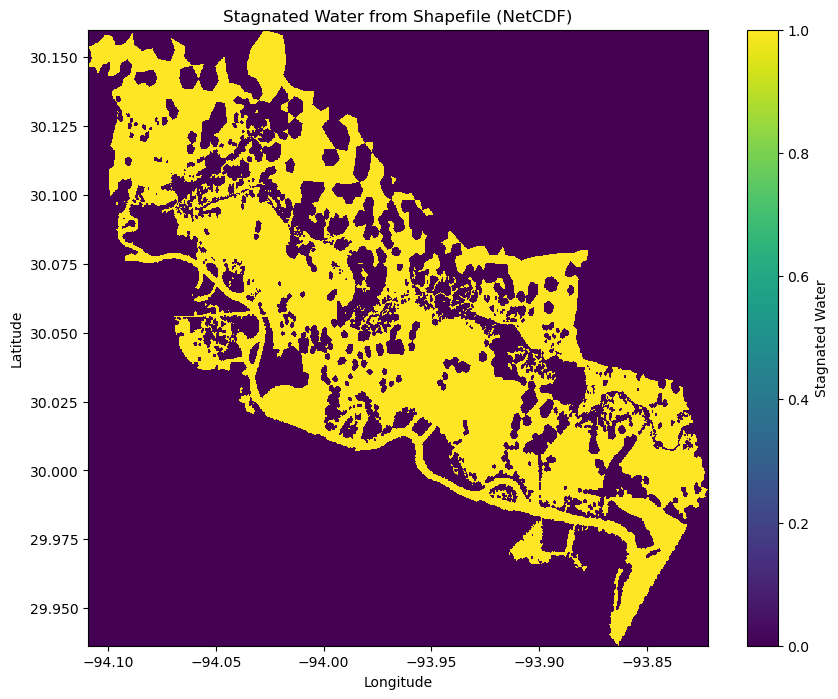

In [42]:

ds = netcdf.Dataset("/Users/liting/Desktop/stag-water/time_index_120/neches_stag.nc", 'r')


# Step 2: Read the variables (lon, lat, and stag_water)
lon = ds.variables['lon'][:]
lat = ds.variables['lat'][:]
stag_water = ds.variables['stag_water'][:]

# Step 3: Create a meshgrid of lon and lat for plotting
lon_grid, lat_grid = np.meshgrid(lon, lat)

# Step 4: Plot using matplotlib
plt.figure(figsize=(10, 8))
plt.pcolormesh(lon_grid, lat_grid, stag_water, shading='auto', cmap='viridis')  # Plot the stag_water variable

# Add a colorbar to show the color intensity corresponding to stag_water values
plt.colorbar(label='Stagnated Water')

# Label axes
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Stagnated Water from Shapefile (NetCDF)')

# Display the plot
plt.show()

# Step 5: Close the NetCDF file
ds.close()
